In [3]:
import sys
# Adding eyenes folder to path
sys.path.insert(1, 'C://Users//arthu//git//eyenes')

from eyenes.agent import Agent
from eyenes.agent_model import AgentModel

Using TensorFlow backend.


In [208]:
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, LSTM, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Reshape
from keras.layers import Softmax, Input, Concatenate, Embedding, Activation, Lambda, Input
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import model_from_json
from keras.initializers import glorot_uniform

import numpy as np


class AgentModel:
    
    model = None
    eye_model = None
    action_model = None
    input_shape = None
    output_dim = None
    activation = None
    buffer = None
    eye_output_dim = None
    
    def __init__(self, buffer, input_shape, output_dim, activation = 'relu'):
        self.buffer = buffer
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.activation = activation
        self.eye_output_dim = 64
        self.start_model()
        
    
    def start_eye_model(self):
        w, h, _ = self.input_shape
        max_dim = max([w,h])
        activation = self.activation

        conv_model = Sequential()

        conv_model.add(Lambda(lambda x: x/255., input_shape = self.input_shape))        
        conv_model.add(ZeroPadding2D(padding = ((max_dim - w)//2, (max_dim - h)//2)))
        conv_model.add(MaxPooling2D((8,8)))

        conv_model.add(Conv2D(4, 4, strides=(2, 2), padding="same", activation=activation))
        conv_model.add(Conv2D(8, 4, strides=(2, 2), padding="same", activation=activation))
        conv_model.add(Conv2D(16,4, strides=(2, 2), padding="same", activation=activation))

        conv_model.add(Flatten())
        conv_model.add(Dense(self.eye_output_dim, activation= activation))
        
        self.eye_model = conv_model
    
    def start_action_model(self):
        
        output_imgs = []
        for i in range(self.buffer):
            output_imgs.append(Input((self.eye_output_dim,)))
        
        output = Concatenate(axis = -1)(output_imgs)
        output = Reshape([self.buffer, self.eye_output_dim])(output)
        output = LSTM(self.eye_output_dim, activation = 'softmax')(output)
        output = Dense(self.output_dim, activation = self.activation)(output)
        
        self.action_model = Model(inputs = output_imgs, outputs = output)
        
    def start_model(self):
        if self.eye_model == None:
            self.start_eye_model()
        
        if self.action_model == None:
            self.start_action_model()
            
        input_imgs = []
        for i in range(self.buffer):
            input_imgs.append(Input(self.input_shape))

        output_imgs = []
        for input_img in input_imgs:
            output_img = input_img
            for layer in self.eye_model.layers:
                output_img = layer(output_img)
            output_imgs.append(output_img)
            
        output = output_imgs
        for layer in self.action_model.layers:
            output = layer(output)
            
        self.model = Model(inputs = input_imgs, outputs = output)        
        
    def mutate(self, freq, intensity):
        mutated_weights = []
        for weight in self.model.get_weights():
            A = np.random.choice([0,1], p=[1-freq, freq], size = np.shape(weight))
            A = A*intensity
            glorot = glorot_uniform().__call__(np.shape(weight))
            mutated_weights.append(A*glorot + weight)
            
        self.model.set_weights(mutated_weights)
            
    def summary(self):
        return self.model.summary()
    
    def get_weights(self):
        return self.model.get_weights()
    
    def set_weights(self, weights):
        return self.model.set_weights(weights)
    
    def predict(self, inputs):
        return self.model.predict(inputs)


In [372]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym import wrappers
from IPython.display import Video
import io
import base64
from IPython.display import HTML
import numpy as np
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import copy

class Agent:
    
    eyemodel = None
    model = None
    state = None
    total_reward = None
    reward = None
    done = None
    info = None
    next_state = None
    update = None
    buffer = None
    freq = None
    intensity = None
    env = None
    ID = None
    lineage = None
    max_steps = None
    fps = None
    lazy_penalty = None
    
    def __init__(self, ID = -1, update = ['reward'], buffer = 3, max_steps = 500, freq = .25, intensity = .25, fps = 5):
        
        self.buffer = buffer
        self.freq = freq
        self.intensity = intensity
        self.env = self.make_env()
        self.start_model()
        self.update = update
        self.state = deque(maxlen = buffer*fps + 1)
        self.ID = ID
        self.max_steps = max_steps
        self.lineage = []
        self.fps = fps
        self.lazy_penalty = -30
        self.death_penalty = -50
        for _ in range(buffer):
            self.state.append(np.zeros(self.env.observation_space.shape))
        
        
    def make_env(self, mode = None, rom_id = 'SuperMarioBros-v0'):
        env = gym_super_mario_bros.make(rom_id)
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        if mode == 'monitor':
            env = wrappers.Monitor(env, directory, force = True)
        return env 
    
    def start_model(self):
        env = self.make_env()
        self.model = AgentModel(buffer = self.buffer, input_shape = env.observation_space.shape, output_dim = env.action_space.n)
    
    def get_buffered_images(self):
        buffered_states = []
        for i in range(self.buffer):
            buffered_states.append(self.state[(i + 1)*self.fps - 1])
        return buffered_states
    
    def take_action(self):
        input_imgs = []
        for input_img in self.get_buffered_images():
            input_imgs.append(np.expand_dims(input_img, axis = 0))
        prediction = self.model.predict(input_imgs)
        return np.argmax(prediction)

    def reset_data(self):
        for i in range(self.buffer*self.fps + 1):
            self.state.append(np.zeros(self.env.observation_space.shape))
        self.total_reward = 0
        self.reward = []
        self.done = []
        self.info = dict()
        self.next_state = []
    
    def gather_data(self, step, state, reward, done, info, next_state):
        self.total_reward += reward
        if step%self.fps == 0:
            self.state.append(np.array(state))

    def run(self, max_steps = 500, mode = None, directory = './gym-results/'):    
        env = self.make_env(mode = mode)
        self.reset_data()
        
        patience = 3
        resting = 0
        x_pos = 0
        state = env.reset()
        prev_state = state
        done = False
        for step in range(max_steps):

            if step%self.fps == 0:
                action = self.take_action()
                
            next_state, reward, done, info = env.step(action)
                            
            if info['x_pos'] > x_pos:
                x_pos = info['x_pos']
                resting = 0
                
            if abs(info['x_pos'] - x_pos) < 5:
                resting += 1
                
            if resting > patience*60:
                self.total_reward += self.lazy_penalty
                break
                
            if info['life'] < 2: 
                self.total_reward += self.death_penalty
                break

            self.gather_data(step, state, reward, done, info, next_state)
            prev_state = state
            state = next_state

            if mode == 'render':
                env.render()

        if mode == 'monitor':
            file_name = directory + 'openaigym.video.%s.video000000.mp4'% env.file_infix
            mp4 = Video(file_name, width = 600, height = 450)
            display(mp4)

        if mode == 'render':    
            env.close()
    
    def get_reward(self):
        if self.total_reward == None:
            self.run()
        return self.total_reward

    def itsame(self):
        return 'Mario!'
    
    def copy_model(self, other, new_ID):
        self.ID = new_ID
        self.lineage = copy.copy(other.lineage)
        if other.ID not in self.lineage:
            self.lineage.append(other.ID)
            
        self.model.set_weights(other.model.get_weights())

    def mutate(self):
        self.model.mutate(freq = self.freq, intensity = self.intensity)
        self.total_reward = None
        
    def print_state(self):
        fig = plt.figure(figsize=(16., 12.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(1, self.buffer),  # creates 2x2 grid of axes
                         axes_pad=0.1,)  # pad between axes in inch.

        
        for ax, im in zip(grid, self.get_buffered_images()):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.show()


In [373]:
agent = Agent(ID = 0, buffer = 3, fps = 3)

In [374]:
agent.run(mode = 'render')

In [375]:
np.shape(agent.state)

(10, 240, 256, 3)

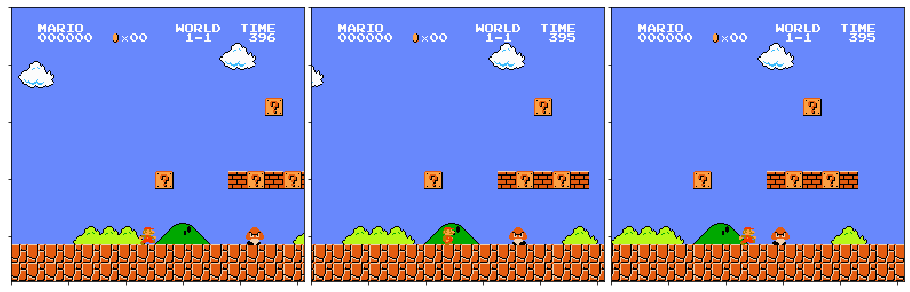

In [376]:
agent.print_state()

In [192]:
generation = [Agent(ID = i) for i in range(10)]

In [210]:
agent = Agent()

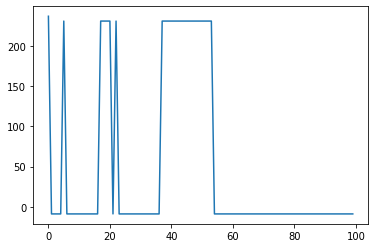

In [212]:
from IPython.display import clear_output

reward_history = []

for i in range(100):
    reward = agent.get_reward()
    reward_history.append(reward)
    agent.mutate()
    clear_output(wait = True)
    plt.plot(reward_history)
    plt.show()

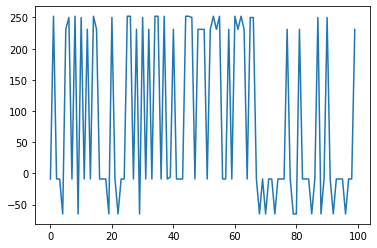

In [214]:
from IPython.display import clear_output

reward_history = []

for i in range(100):
    reward = agent.get_reward()
    reward_history.append(reward)
    agent = Agent()
    clear_output(wait = True)
    plt.plot(reward_history)
    plt.show()

In [ ]:
agent.